<a href="https://colab.research.google.com/github/MasterDawn/bigdata23/blob/master/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, we load the anomaly dataset into a pandas dataframe

In [245]:
import pandas as pd

df_anomaly = pd.read_csv("anomaly.csv", header=None, names = ["X", "Y"] )
df_anomaly.head()

,X,Y
0,4.591209,5.170707
1,3.000957,3.639456
2,5.414689,5.464908
3,3.312763,2.394599
4,3.341148,2.249067


We apply standardisation to the numbers within the dataframe, even though the numbers were not too dissimilar in scale. This is done because we will make use of the euclidean distance. 

In [247]:
from sklearn.preprocessing import StandardScaler

scaled_anomalies = StandardScaler().fit_transform(df_anomaly.values)
df_scaled_anomalies = pd.DataFrame(scaled_anomalies, index=df_anomaly.index, columns=["Standardized X", "Standardized Y"])

print(df_scaled_anomalies.head())

   Standardized X  Standardized Y
0        1.279516        1.486504
1       -0.532910        0.204888
2        2.218044        1.732741
3       -0.177542       -0.837023
4       -0.145191       -0.958830


Next, we check the dataset for missing values or odd types.




Standardized X    float64
Standardized Y    float64
dtype: object

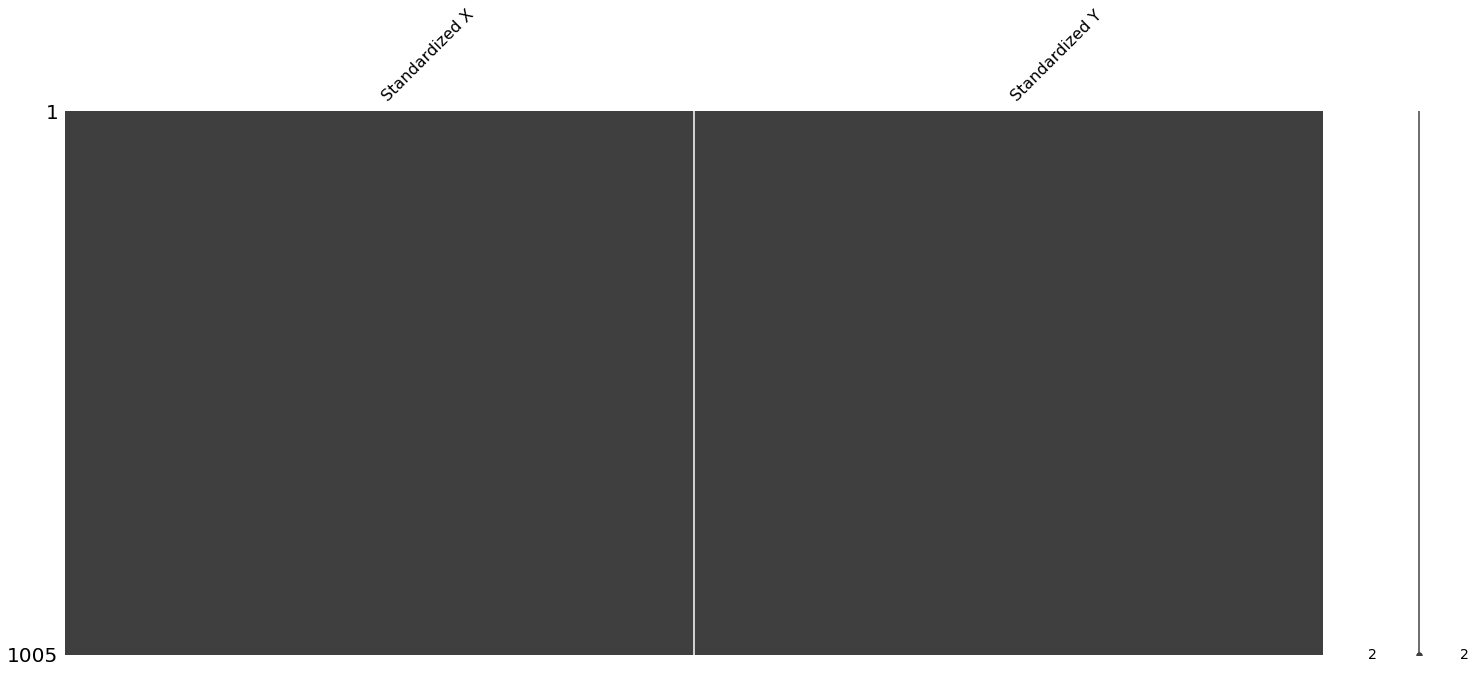

In [248]:
import missingno

missingno.matrix(df_scaled_anomalies)
df_scaled_anomalies.dtypes

This shows that there are no missing values present in the dataset. Now we visualise the 2D data to see where each point is located using the plotly library. 


In [250]:
import plotly.express as px
fig = px.scatter(df_scaled_anomalies, x="Standardized X", y="Standardized Y")
fig.show()

Clearly, some clusters (likely 5 gaussian-shaped ones) are present within our given data. We will now try to use some unsupervised anomaly detection algorithms to gain insight into the data. Some useful Algorithms are discussed in [this](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152173) article.

CONCLUSION: nearest-neighbor based algorithms perform better in most cases when compared to clustering algorithms. Global outlier algorithms in general outperform local ones. As a general summary for algorithm selection, use nearest-neighbor based methods, in particular k-NN for global tasks and LOF for local tasks instead of clustering-based methods.

Since we have to implement dedicated anomaly detection ourselves, we will investigate both the KNN and a gaussian approach.


**KNN Algorithm**

> k needs to be chosen, typically above the smallest cluster size +1. 

KNN is available in two flavors: Either the distance to the kth-nearest-neighbor is used (a single one) or the average distance to all of the k-nearest-neighbors. We implement the average distance-based version. To improve computation speed, we will rely on a KD-based implementation.

We define a KNN class based on the KDTree implementation available in sklearn

In [263]:
import numpy as np
from sklearn.neighbors import KDTree   # We were allowed to use KD trees by David

class KNN():
  def __init__(self, df, amnt_neighbors):
      self.tree = KDTree(df, leaf_size=30)  # leaf size is just important forr speed optimisation, not for results
      self.amnt_neighbors = amnt_neighbors
  
  def predict(self, np_array):
      return self.tree.query(np_array, self.amnt_neighbors)

knn_model = KNN(df_scaled_anomalies, 5)
dist2, ind2 = knn_model.predict([[2, 3], [4, 5.12], [777, 0.2351]])

print(dist2, ind2)

[[  1.10353822   1.15913624   1.21210798   1.23583941   1.26083727]
 [  3.63746461   3.8137466    3.8273867    3.82867425   3.88241313]
 [774.32977358 774.33031538 774.49046272 774.56906592 774.58446997]] [[372 570 817 712 385]
 [331 712   2 861 509]
 [331 861 144 357 833]]


In [264]:
distances_knn, indexes_knn = knn_model.predict(df_scaled_anomalies)

In [265]:
fig = px.scatter(x = df_scaled_anomalies["Standardized X"].values , y = distances_knn.mean(axis=1))
fig.show()

We see that some abnormal points exist. In particular, three outliers dominate

In [266]:
df_anomaly_fin = df_scaled_anomalies.copy()
df_anomaly_fin["Outlier Score"] = distances_knn.mean(axis=1)

fig = px.scatter(df_anomaly_fin, x="Standardized X", y="Standardized Y", size="Outlier Score")
fig.show()

In [253]:
def is_anomaly(score, threshold):
  if score >= threshold:
    return "Anomaly"
  return "Normal"

threshold = 0.20
#anomaly_class = df_anomaly_fin.apply(lambda row: is_anomaly(row["Outlier Score"], threshold), axis=1)
anomaly_class = np.where(df_anomaly_fin["Outlier Score"].values >= threshold, "Anomaly", "Normal")
df_anomaly_fin["Classification"] = anomaly_class

fig = px.scatter(df_anomaly_fin, x="Standardized X", y="Standardized Y", size="Outlier Score", color="Classification")
fig.show()

**Gaussian Mixture Based Classification**

We combine several gaussian functions which aim to estimate the density. The idea here is that unlikely points will have significantly lower probability, hence we will be able to detect them

In [267]:
import numpy as np
from sklearn.mixture import GaussianMixture

cluster_amnt = np.arange(1, 15)
models = [GaussianMixture(n_components = amnt_comp, covariance_type='full', random_state=0).fit(df_scaled_anomalies)
          for amnt_comp in cluster_amnt]

BIC = [model.bic(df_scaled_anomalies) for model in models]
AIC = [model.aic(df_scaled_anomalies) for model in models]

fig = px.scatter(x = cluster_amnt, y = BIC)
fig.show()

In [268]:
fig = px.scatter(x = cluster_amnt, y = AIC)
fig.show()

The optimal amount of clusters is the minimum of either the BIC or AIC. I chose to continue based on the BIC version, but replacing BIC by AIC in the following code is also valid

In [269]:
# We need np.argmin(BIC) + 1, as at index 0 there is 1 gaussian function present 
gm = GaussianMixture(n_components = np.argmin(BIC) + 1, covariance_type='full', random_state=0).fit(df_scaled_anomalies)
gm.fit(df_scaled_anomalies)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Next, we visualise the contours based [this](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html) example

In [270]:
x = np.linspace(-3.0, 3.0)
y = np.linspace(-3.0, 3.0)
X, Y = np.meshgrid(x, y)

XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gm.score_samples(XX)

dens_map = np.append(XX, Z.reshape((len(Z), 1)), axis=1)
print(Z)
pd_dens_map = pd.DataFrame(dens_map, columns = ['Standardized X','Standardized Y','Likelihood'])

[50.37369314 47.74795624 45.32894404 ... 43.32079836 45.45288736
 47.76366351]


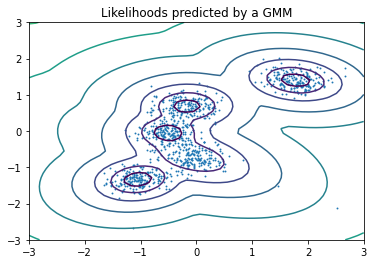

In [271]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Z = Z.reshape(X.shape)


CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
plt.scatter(df_scaled_anomalies["Standardized X"], df_scaled_anomalies["Standardized Y"], .8)

plt.title('Likelihoods predicted by a GMM')
plt.show()

In [ ]:
anomaly_scores_gmm = -gm.score_samples(df_scaled_anomalies)

In [272]:
df_anomaly_gmm = df_scaled_anomalies.copy()
df_anomaly_gmm["Outlier Score"] = anomaly_scores_gmm

# the final algorithm will not use threshold but returns the score. This PM serves to play with the visuals
threshold = 5

anomaly_class_gmm = np.where(df_anomaly_gmm["Outlier Score"].values >= threshold, "Anomaly", "Normal")
df_anomaly_gmm["Outlier Score"] = anomaly_scores_gmm
df_anomaly_gmm["Classification"] = anomaly_class_gmm

fig = px.scatter(df_anomaly_gmm, x="Standardized X", y="Standardized Y", size="Outlier Score", color="Classification")
fig.show()